# Analyze the BD results

In [1]:
%load_ext autotime

import scvelo as scv
import loompy
import scanpy
import igraph
import phate
import glob, os
import pandas as pd
import os
import re
import subprocess
from collections import Counter
import numpy as np
from shutil import rmtree
import os
import anndata

import h5py
from shutil import copyfile


def copyFiles(files, to):
    for f in files:
        name = os.path.basename( f )
        print( f"copy {f} to {to}" )
        copyfile( f, os.path.join(to, name ) )
    print( "all copied" )

time: 1.92 s (started: 2023-02-08 09:15:12 +01:00)


In [2]:
files = [ 'Combined_S1Subset_DBEC_MolsPerCell.csv', 'Combined_S2Subset_DBEC_MolsPerCell.csv' ]
sinfoF = [ 'S1Subset_Sample_Tag_Calls.csv', 'S2Subset_Sample_Tag_Calls.csv']
sname = ['S1_BD', 'S2_BD' ]

ofiile = "BD_analyzed.h5ad"

time: 257 µs (started: 2023-02-08 09:15:14 +01:00)


In [3]:
df = pd.read_csv(files[0], skiprows=7, index_col=0)
df.columns[0:20]

Index(['CD117:2B8|Kit|AMM2023|pAbO', 'CD19|Cd19|AMM2007|pAbO',
       'CD25:PC61|Il2ra|AMM2012|pAbO', 'CD5|Cd5|AMM2043|pAbO',
       'IgM|Ighm|AMM2031|pAbO', '2810417H13Rik', 'Ada', 'Adgre1', 'Adgrg3',
       'Aicda', 'Alas2', 'Anxa5', 'Apoe', 'Aqp9', 'Arg1', 'Arg2', 'Arid3a',
       'Arl4c', 'Atf6b', 'Atg5'],
      dtype='object')

time: 18.6 ms (started: 2023-02-08 09:15:14 +01:00)


In [4]:
m = np.array([ s.__contains__ ("|") for s in df.columns ]).sum()

time: 24.6 ms (started: 2023-02-08 09:15:14 +01:00)


In [5]:
adata = anndata.AnnData(X = df.iloc[0:,m:])

time: 3.39 ms (started: 2023-02-08 09:15:14 +01:00)


In [6]:
adata.var_names
adata.obs['sample'] = sname[0]

time: 2.27 ms (started: 2023-02-08 09:15:14 +01:00)


In [7]:
df = pd.read_csv(files[1], skiprows=7, index_col=0)
tmp = anndata.AnnData(X = df.iloc[0:,m:])
tmp.obs['sample'] = sname[1]
adata = adata.concatenate( tmp )

time: 15.3 ms (started: 2023-02-08 09:15:14 +01:00)


In [8]:
if not os.path.exists("Rustody_S1"):
    f1 = "../cells.1.Rhapsody_SV_index1_S1_R1_001.fastq.gz"
    f2 = "../cells.1.Rhapsody_SV_index1_S1_R2_001.fastq.gz"
    ab = "../MyAbSeqPanel.fasta"
    ex = "../2276_20220531_chang_to_rpl36a_amplicons.fasta"
    ! ../../target/release/quantify_rhapsody -r {f1} -f {f2} -o Rustody_S1 -s mouse  -e {ex} -a {ab} -m 200 -v v2.96

time: 342 µs (started: 2023-02-08 09:15:14 +01:00)


In [9]:
if not os.path.exists("Rustody_S2"):
    f1 = "../cells.1.Rhapsody_SV_index2_S2_R1_001.fastq.gz"
    f2 = "../cells.1.Rhapsody_SV_index2_S2_R2_001.fastq.gz"
    ab = "../MyAbSeqPanel.fasta"
    ex = "../2276_20220531_chang_to_rpl36a_amplicons.fasta"
    ! ../../target/release/quantify_rhapsody -r {f1} -f {f2} -o Rustody_S2 -s mouse  -e {ex} -a {ab} -m 200 -v v2.96

time: 5.02 ms (started: 2023-02-08 09:15:14 +01:00)


In [10]:
def readRustodyExpression(path, name):
    print(f"reading Rustody expression from path {path}/BD_Rhapsody_expression/")
    this = scanpy.read_10x_mtx( path+'/BD_Rhapsody_expression/' )
    this.obs['sample'] = name
    obs1 = pd.read_csv( path+'/SampleCounts.tsv', sep="\t")
    this.obs = this.obs.merge( obs1, left_index= True, right_on = 'CellID' )
    this.obs_names = this.obs['CellID'] + "_" +  this.obs['sample']
    this = this[this.obs['AsignedSampleName'] != "na"]
    this.obs['AsignedSampleName'] = this.obs['AsignedSampleName'] + "_" + this.obs['sample']
    return(this)

time: 1.96 ms (started: 2023-02-08 09:15:14 +01:00)


In [11]:
adata = adata.concatenate( readRustodyExpression( 'Rustody_S1', 'S1_Rustody') )
adata = adata.concatenate( readRustodyExpression( 'Rustody_S2', 'S2_Rustody') )


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


reading Rustody expression from path Rustody_S1/BD_Rhapsody_expression/
reading Rustody expression from path Rustody_S2/BD_Rhapsody_expression/
time: 44.2 ms (started: 2023-02-08 09:15:14 +01:00)


In [12]:
Counter( adata.obs['sample'])

Counter({'S1_BD': 99, 'S2_BD': 31, 'S1_Rustody': 54, 'S2_Rustody': 34})

time: 1.54 ms (started: 2023-02-08 09:15:14 +01:00)


In [13]:
scanpy.pp.filter_genes(adata, min_counts=1 )
scanpy.pp.filter_cells(adata, min_genes=20 )
Counter( adata.obs['sample'])

Counter({'S1_BD': 51, 'S2_BD': 30, 'S1_Rustody': 49, 'S2_Rustody': 31})

time: 6.39 ms (started: 2023-02-08 09:15:14 +01:00)


In [14]:
scanpy.pp.calculate_qc_metrics( adata, inplace=True, log1p=True, percent_top= [10])

time: 20.3 ms (started: 2023-02-08 09:15:14 +01:00)


In [15]:
scanpy.pp.filter_cells(adata, min_counts=400 )
scanpy.pp.downsample_counts(adata, counts_per_cell= 400 )
scv.pp.log1p(adata)
Counter( adata.obs['sample'])

Counter({'S1_BD': 47, 'S2_BD': 27, 'S1_Rustody': 47, 'S2_Rustody': 30})

time: 15.9 ms (started: 2023-02-08 09:15:14 +01:00)


In [16]:
scanpy.pp.neighbors(adata)
dimensions = 2
scanpy.tl.umap(adata,n_components= dimensions)

         Falling back to preprocessing with `sc.pp.pca` and default params.
time: 4.06 s (started: 2023-02-08 09:15:14 +01:00)


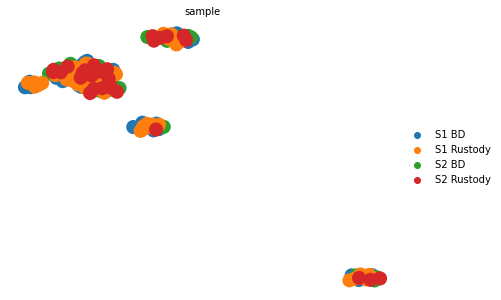

time: 103 ms (started: 2023-02-08 09:15:18 +01:00)


In [17]:
scv.pl.scatter(adata, color='sample', figsize =(7,5), legend_loc='right margin')

In [18]:
scanpy.tl.louvain(adata)

time: 4.47 ms (started: 2023-02-08 09:15:19 +01:00)


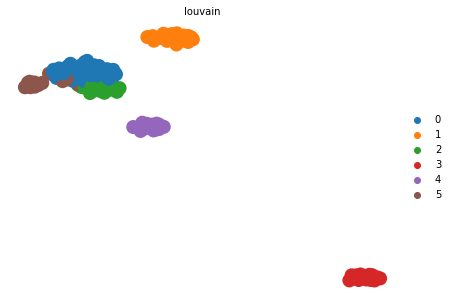

time: 110 ms (started: 2023-02-08 09:15:19 +01:00)


In [19]:
scv.pl.scatter(adata, color='louvain', figsize =(7,5), legend_loc='right margin')

In [20]:
adata.obs.pivot_table(values = "n_genes", index = "louvain", columns="sample", aggfunc='count')

sample,S1_BD,S1_Rustody,S2_BD,S2_Rustody
louvain,,,,
0,13,14,12,14
1,6,7,6,6
2,7,6,4,6
3,6,6,3,3
4,8,7,1,1
5,7,7,1,0


time: 8.66 ms (started: 2023-02-08 09:15:19 +01:00)


In [21]:
adata.obs['n_genes' ] = adata.obs['n_genes' ].astype('int32')

time: 474 µs (started: 2023-02-08 09:15:19 +01:00)


In [22]:
adata

AnnData object with n_obs × n_vars = 151 × 244
    obs: 'sample', 'batch', 'CellID', 'Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5', 'Sample6', 'Sample7', 'Sample8', 'Sample9', 'Sample10', 'Sample11', 'Sample12', 'AsignedSampleName', 'FractionTotal', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'n_counts', 'louvain'
    var: 'gene_ids-1-0', 'feature_types-1-0', 'gene_ids-1', 'feature_types-1', 'n_counts', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'sample_colors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

time: 2.83 ms (started: 2023-02-08 09:15:19 +01:00)


... storing 'feature_types-1-0' as categorical
... storing 'feature_types-1' as categorical


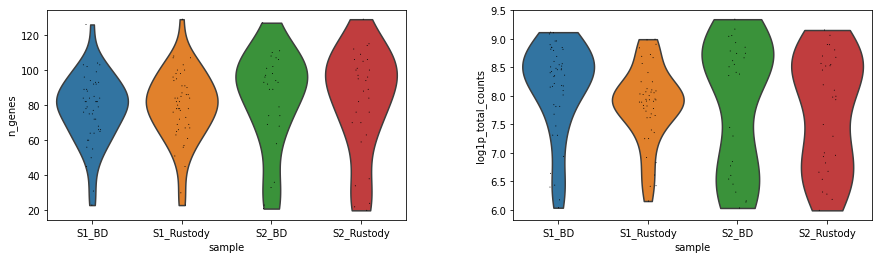

time: 144 ms (started: 2023-02-08 09:15:19 +01:00)


In [23]:
scanpy.pl.violin(adata, [ 'n_genes', 'log1p_total_counts' ], 'sample')

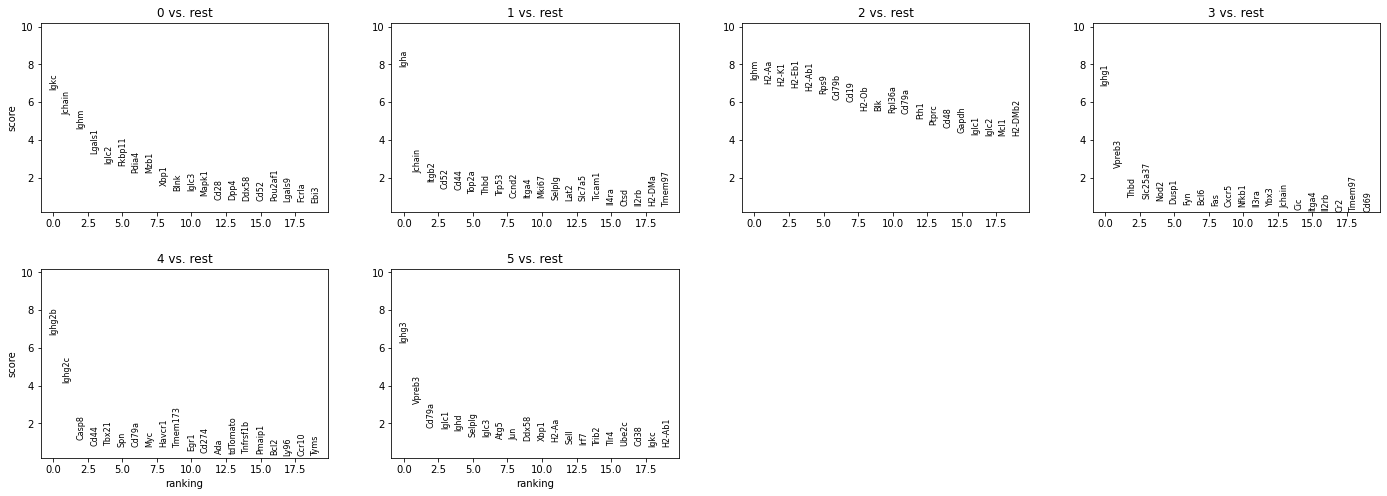

time: 603 ms (started: 2023-02-08 09:16:32 +01:00)


In [24]:
key_added = "louvain"
scanpy.tl.rank_genes_groups(
    adata, 
    groupby   = 'louvain',
    key_added = key_added,
    method    = 'wilcoxon',
)

scanpy.pl.rank_genes_groups(adata, key = key_added )

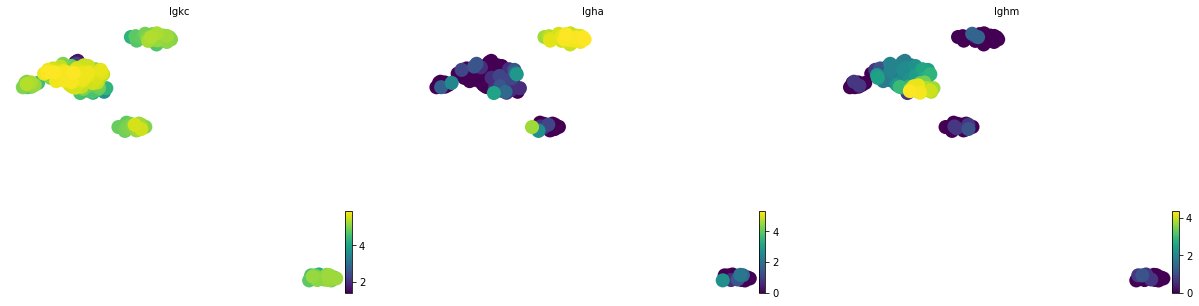

time: 201 ms (started: 2023-02-08 09:18:38 +01:00)


In [26]:
scv.pl.scatter(adata, color=['Igkc', 'Igha', 'Ighm'], figsize =(7,5), legend_loc='right margin')

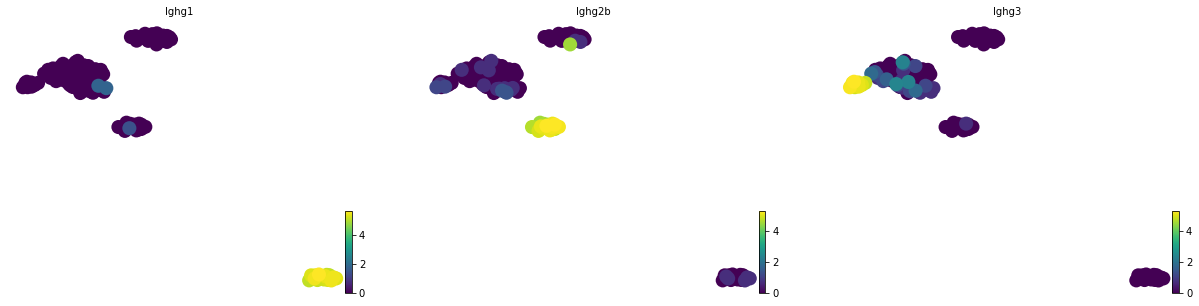

time: 209 ms (started: 2023-02-08 09:18:38 +01:00)


In [27]:
scv.pl.scatter(adata, color=[ 'Ighg1', 'Ighg2b', 'Ighg3' ], figsize =(7,5), legend_loc='right margin')

S1_BD


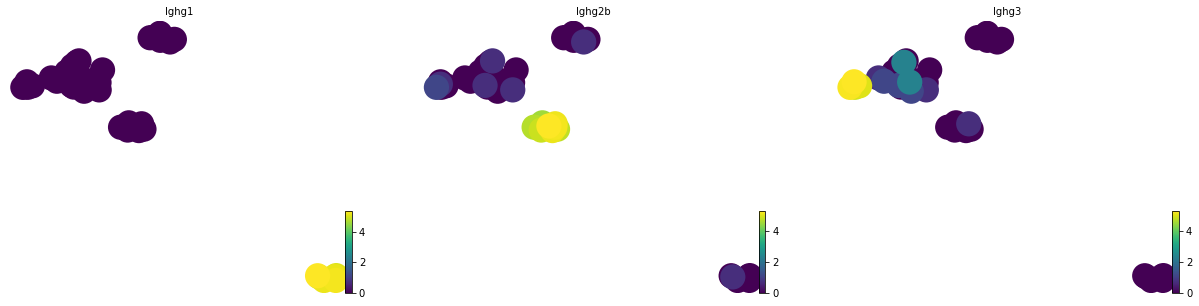

S2_BD


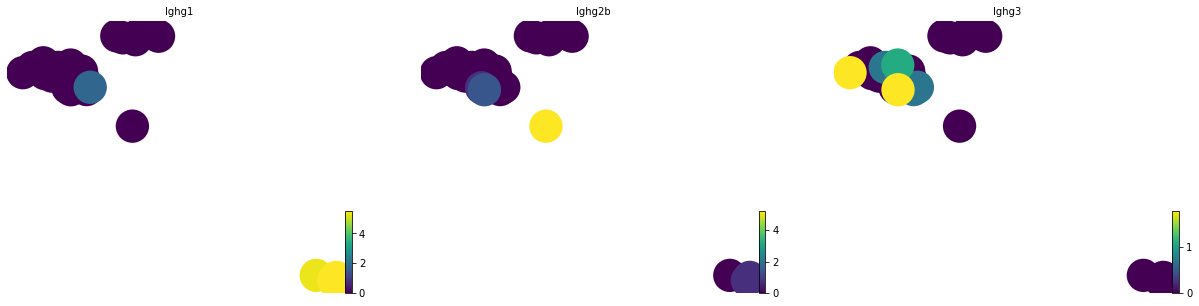

S1_Rustody


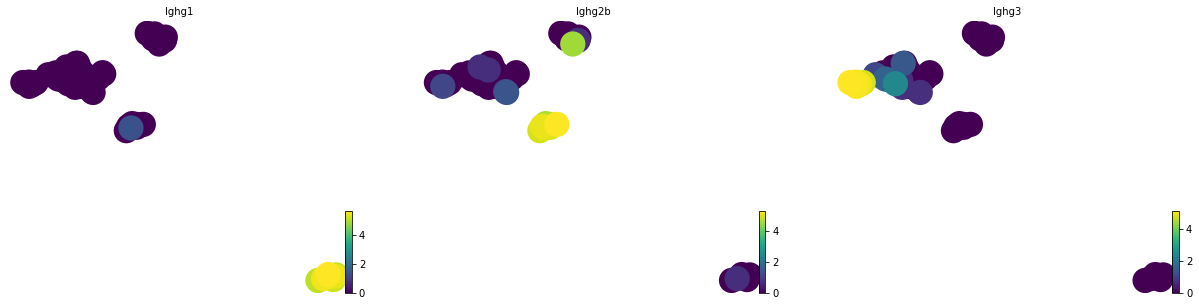

S2_Rustody


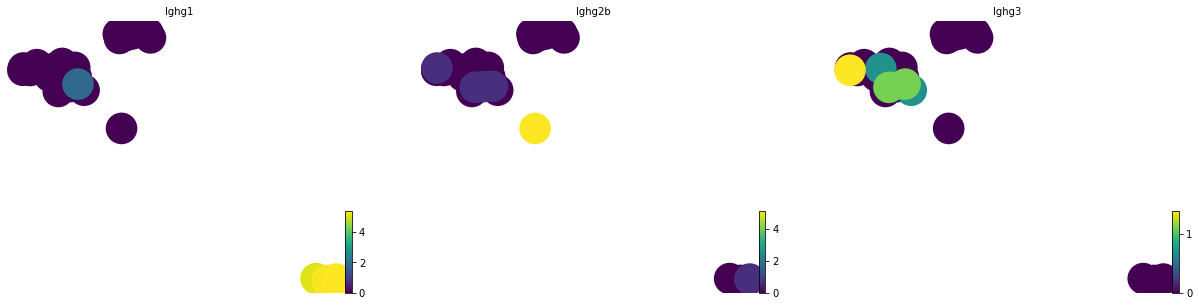

time: 745 ms (started: 2023-02-08 09:21:03 +01:00)


In [29]:
for n in adata.obs['sample'].unique():
    print (n)
    scv.pl.scatter(adata[adata.obs['sample'] == n], color=[ 'Ighg1', 'Ighg2b', 'Ighg3' ], figsize =(7,5), legend_loc='right margin')

S1_BD


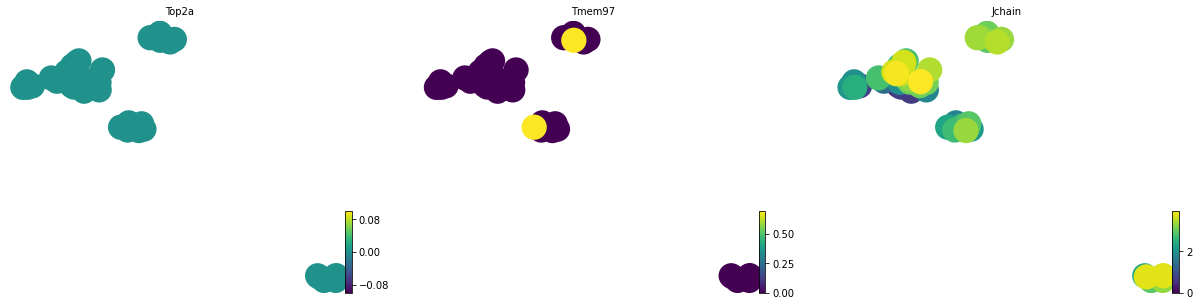

S2_BD


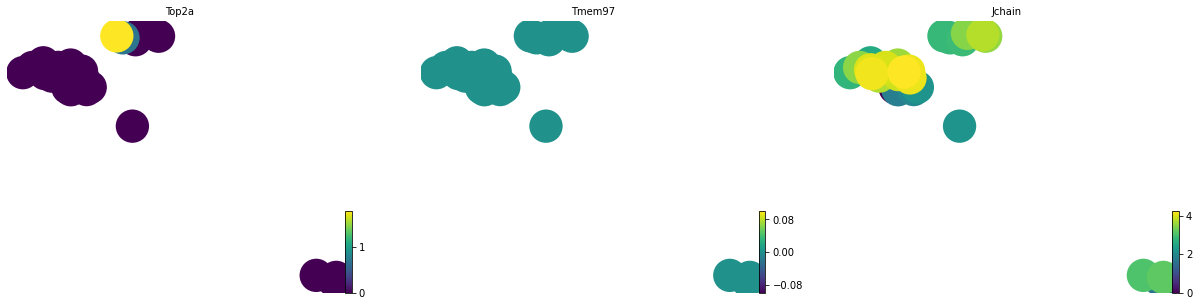

S1_Rustody


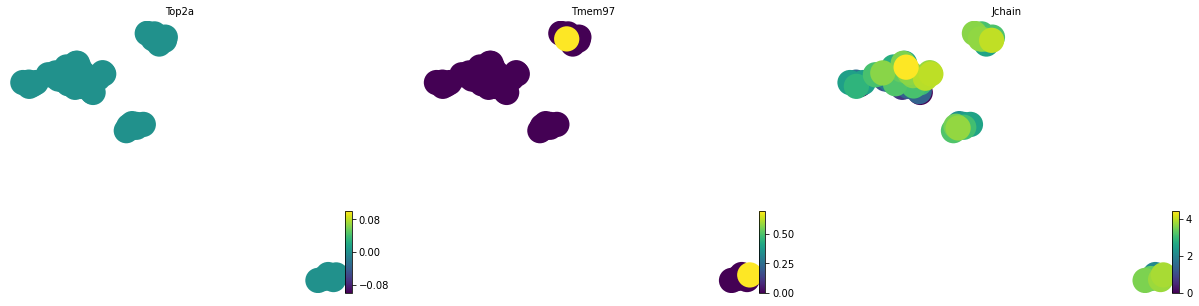

S2_Rustody


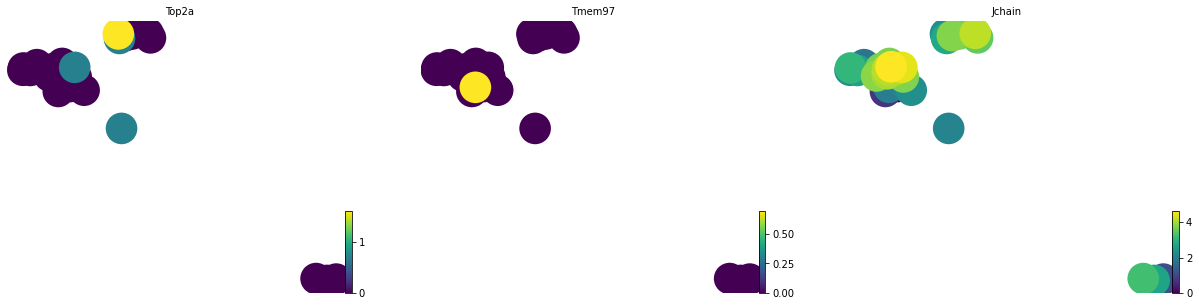

time: 767 ms (started: 2023-02-08 09:24:12 +01:00)


In [31]:
for n in adata.obs['sample'].unique():
    print (n)
    scv.pl.scatter(adata[adata.obs['sample'] == n], color=[ 'Top2a', 'Tmem97', 'Jchain' ], figsize =(7,5), legend_loc='right margin')